# **Store Item Demand Forecasting Project**

### **Abstract**

Hello everyone! My name is Ignacio Antequera Sanchez, and the objective of this project is to tackle the Store Item Demand Forecasting challenge, a competition hosted on Kaggle. This project leverages machine learning techniques to forecast the demand for items in a retail setting. Accurate demand forecasting is a crucial component of supply chain management and inventory optimization, and this project aims to demonstrate the power of deep learning in this domain.

### **Introduction**

In the dynamic world of retail and supply chain management, predicting the future demand for store items is a complex yet essential task. It plays a pivotal role in ensuring that the right products are available in the right quantities at the right time, ultimately influencing customer satisfaction and business profitability.

This project is designed to address this challenge by harnessing the potential of machine learning, specifically deep learning, to provide accurate and timely demand forecasts. In this endeavor, we will explore various techniques and methodologies to tackle this problem effectively.

***

The data used in this project can be found in the following link: [Data](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data).

### **Agenda**

Our project will follow a structured agenda to achieve the goal of accurate demand forecasting. Here's what we plan to cover:

1. Data Exploration and Preprocessing:
    Understand and clean the dataset.
    Explore temporal patterns.
2. Feature Engineering:
    Create datetime-related and domain-specific features.
3. Model Selection and Tuning:
    Implement and optimize forecasting models, including XGBoost.
    Explore alternative models.
4. Evaluation and Metrics:
    Choose and apply evaluation metrics.
    Use time series cross-validation.
5. Ensemble Techniques:
    Investigate ensemble methods for improved accuracy.
6. Documentation and Reporting:
    Document code, methodologies, and findings.
    Share insights with the community.

## **Data Exploration and Preprocessing**

### Import Libraries

In [1]:
# Import necessary libraries for data exploration and preprocessing
import pandas as pd         # Data manipulation and analysis
import numpy as np          # Numerical operations
import matplotlib.pyplot as plt  # Data visualization
import datetime             # Date and time manipulation

from sklearn.model_selection import train_test_split, TimeSeriesSplit  # Data splitting and time series cross-validation
from sklearn.metrics import mean_absolute_error  # Metric for model evaluation

# XGBoost, a machine learning library for gradient boosting
import xgboost as xgb

### Import Data and Explore Dataset.

In [2]:
# Import the training dataset
train = pd.read_csv("data/train.csv")

# Import the testing dataset
test = pd.read_csv("data/test.csv")

Let's look at the features from our test and train datasets

In [3]:
print('Features of our test set: ')
test.columns

Features of our test set: 


Index(['id', 'date', 'store', 'item'], dtype='object')

In [4]:
print('Features of our training set: ')
train.columns

Features of our training set: 


Index(['date', 'store', 'item', 'sales'], dtype='object')

Now, let's display the dimensions (number of rows and columns) of the train and test DataFrames

In [5]:
print(train.shape,test.shape)

(913000, 4) (45000, 4)


As expected:
- The training dataset (train) contains 91,3000 samples (rows) and 4 columns.
- The testing dataset (test) contains 45,000 samples (rows) and 4 columns.

Let's look at how many unique values we have in both the traininig and test datasets

In [6]:
# List of columns to display unique values
columns_to_display = ['store', 'item']

# Iterate through the columns and datasets
for column in columns_to_display:
    print(f'Unique values in {column} (Training Data): {train[column].unique()}')
    print(f'Unique values in {column} (Testing Data): {test[column].unique()}')
    print()

Unique values in store (Training Data): [ 1  2  3  4  5  6  7  8  9 10]
Unique values in store (Testing Data): [ 1  2  3  4  5  6  7  8  9 10]

Unique values in item (Training Data): [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]
Unique values in item (Testing Data): [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]



Let's calculate the Symmetric Mean Absolute Percentage Error (SMAPE), which is a metric commonly used to measure the accuracy of forecasting models, especially in time series forecasting tasks.

In [7]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

- `A` represents the actual values, typically the true demand or sales values for your items in your testing dataset.
- `F` represents the forecasted or predicted values generated by your demand forecasting model for the same items in your testing dataset.

Since 10 * 50 * (365 + 365 + 365 + 366 +365) = 913000, we know that:

- The train data of (date , store , item) is complete during 2013 -2017
- The test data of (date , store , item) is complete during 2018.01.01 - 2018.03.31

This indicates that the training data spans from 2013 to 2017, while the testing data covers the first quarter of 2018. SMAPE is relevant here because it can help us assess how well your forecasting model performs on this out-of-sample testing data by quantifying the percentage accuracy of your predictions compared to the actual demand.

### Explore the data seasonality of the data.

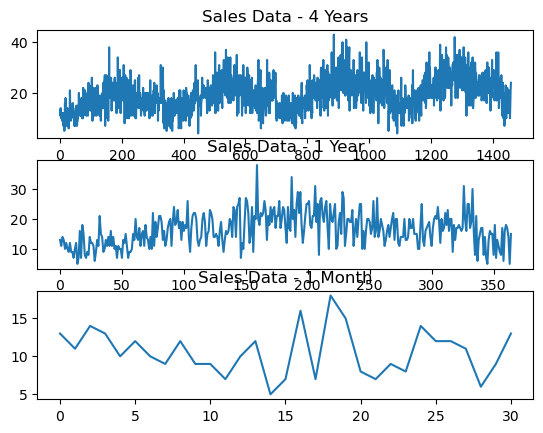

In [8]:
# Create subplots with a 3-row, 1-column grid and select the first subplot
plt.subplot(3, 1, 1)

# Plot the sales data for the first 4 years (365*4 days)
plt.plot(train.sales[:365*4])
plt.title('Sales Data - 4 Years')

# Select the second subplot
plt.subplot(3, 1, 2)

# Plot the sales data for the first year (365 days)
plt.plot(train.sales[:365])
plt.title('Sales Data - 1 Year')

# Select the third subplot
plt.subplot(3, 1, 3)

# Plot the sales data for the first month (31 days)
plt.plot(train.sales[:31])
plt.title('Sales Data - 1 Month')

# Display the subplots
plt.show()

I am visualizing the sales data at different time scales to assess its seasonality:

- In the first subplot, I'm plotting a portion of the sales data, likely spanning a few years, to examine long-term seasonality trends.
- In the second subplot, I'm plotting a shorter period, potentially a year, to look at annual seasonality.
- In the third subplot, I'm plotting an even shorter period, possibly a month, to examine monthly seasonality.

I've noted that there is a very strong seasonality in the data, which is a common characteristic of time series data in retail. Additionally, I mentioned that the feature space (the number of unique time series, which in my case is likely a combination of 'store' and 'item') is large.

As I mentioned previously in this project, I tried using LSTM (Long Short-Term Memory), which is a type of recurrent neural network (RNN), but found it not performing well for this data. I've referred to discussions on datascience.stackexchange and François Chollet's book on deep learning, which suggest that complex neural network models may not be suitable for capturing very long-term dependencies in time series data.

Therefore, Given the observed seasonality and the challenges of using complex neural networks for this task, I've decided to use XGBoost, which is a gradient boosting algorithm. XGBoost is a strong choice for time series forecasting and can often handle seasonality and complex relationships in the data effectively.

This decision aligns with our project agenda, since I mentioned that we would be exploring various forecasting models, including XGBoost, to optimize the demand forecasting.

### Calculate the rolling mean of the 'sales' column

The rolling mean is a smoothed version of the original time series and can be useful for visualizing trends by reducing noise in the data.

In [9]:
# Calculate the rolling mean with a window size of 7
rolling_mean = train.sales.rolling(window=7).mean()

# Print the shape of the resulting rolling mean series
print(rolling_mean.shape)

# Print the first 31 values of the rolling mean series
print(rolling_mean[:31])

(913000,)
0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
6     11.857143
7     11.285714
8     11.428571
9     10.714286
10    10.142857
11     9.714286
12     9.428571
13     9.714286
14     9.142857
15     8.428571
16     9.428571
17     9.142857
18    10.714286
19    11.428571
20    10.857143
21    11.142857
22    11.428571
23    10.285714
24    11.285714
25    10.428571
26    10.000000
27    10.428571
28    10.285714
29    10.285714
30    11.000000
Name: sales, dtype: float64


Let's visualize the rolling mean at different time scales (4 years, 1 year, and 1 month) using Matplotlib subplots. The purpose is to observe how the rolling mean changes over time and at different granularities, providing insights into the underlying trends and seasonality in the data.

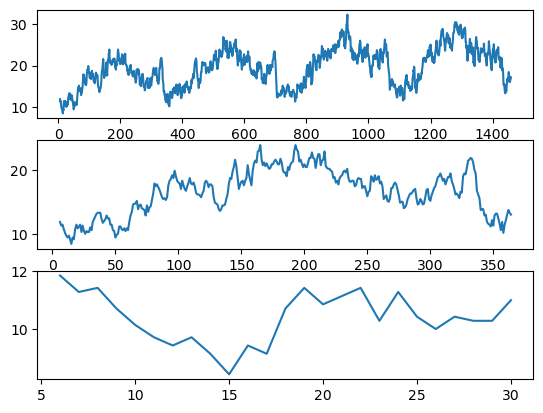

In [10]:
# Calculate the rolling mean with a window size of 7
rolling_mean = train.sales.rolling(window=7).mean()

# Create subplots with a 3-row, 1-column grid and select the first subplot
plt.subplot(3, 1, 1)
# Plot the rolling mean for the first 4 years (365*4 days)
plt.plot(rolling_mean[:365*4])

# Select the second subplot
plt.subplot(3, 1, 2)
# Plot the rolling mean for the first year (365 days)
plt.plot(rolling_mean[:365])

# Select the third subplot
plt.subplot(3, 1, 3)
# Plot the rolling mean for the first month (31 days)
plt.plot(rolling_mean[:31])

# Display the subplots
plt.show()

Let's repeat this calculation, this time with a larger window size of 30, and then visualize this rolling mean at different time scales (4 years and 1 year) using Matplotlib subplots.

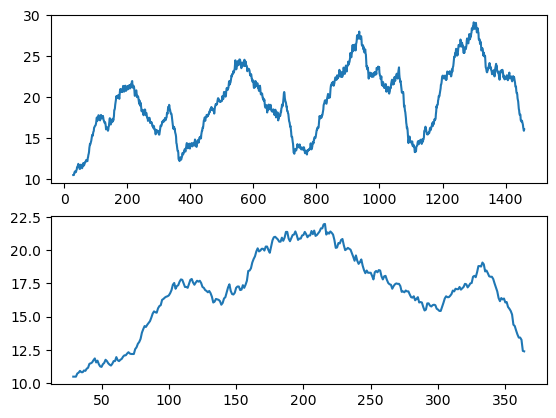

In [11]:
# Calculate the rolling mean with a window size of 30
rolling_mean2 = train.sales.rolling(window=30).mean()

# Create subplots with a 2-row, 1-column grid and select the first subplot
plt.subplot(2, 1, 1)
# Plot the rolling mean for the first 4 years (365*4 days)
plt.plot(rolling_mean2[:365*4])

# Select the second subplot
plt.subplot(2, 1, 2)
# Plot the rolling mean for the first year (365 days)
plt.plot(rolling_mean2[:365])

# Display the subplots
plt.show()

### Combine the train and test data

In [12]:
# Concatenate the training and testing datasets along rows
data_combine = pd.concat([train, test])

# Print the size (number of rows and columns) of the combined dataset
print("Size of data_combine:", data_combine.shape)

Size of data_combine: (958000, 5)


These operations are common in time series analysis and forecasting. By extracting these datetime-related features, you can provide the model with additional information that might capture seasonality, trends, or other temporal patterns in the data. For example, 'month' and 'weekday' features can help the model understand monthly and weekly patterns, respectively. 'Year' and 'week_of_year' can also capture longer-term trends and patterns.

After running the following code, data_combine will have additional columns ('month', 'weekday', 'year', 'week_of_year') that provide temporal information extracted from the original 'date' column.

In [13]:
# Convert the 'date' column to datetime format
data_combine['date'] = pd.to_datetime(data_combine['date'], infer_datetime_format=True)

# Extract month, weekday, year, and week of the year from the 'date' column
data_combine['month'] = data_combine['date'].dt.month
data_combine['weekday'] = data_combine['date'].dt.dayofweek
data_combine['year'] = data_combine['date'].dt.year
data_combine['week_of_year'] = data_combine['date'].dt.weekofyear

C:\Users\nacho\AppData\Local\Temp\ipykernel_14716\385125901.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data_combine['week_of_year'] = data_combine['date'].dt.weekofyear


In [14]:
# Calculate the number of days since January 1, 2013
data_combine['date_order'] = (data_combine['date'] - datetime.datetime(2013, 1, 1)).dt.days

After running this code, the 'date_order' column will contain numeric values representing the sequential order of days since January 1, 2013. This kind of transformation can be useful when dealing with time series data, as it provides a numerical representation of the temporal aspect, making it easier for models to capture and learn patterns related to time.

Let us show the first 100 rows of the data_combine DataFrame, allowing us to inspect the newly added columns, their values, and the overall structure of the data.

In [15]:
data_combine.head(100)

,date,store,item,sales,id,month,weekday,year,week_of_year,date_order
0,2013-01-01,1,1,13.0,NaN,1,1,2013,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2013,1,1
2,2013-01-03,1,1,14.0,NaN,1,3,2013,1,2
3,2013-01-04,1,1,13.0,NaN,1,4,2013,1,3
4,2013-01-05,1,1,10.0,NaN,1,5,2013,1,4
...,...,...,...,...,...,...,...,...,...,...
95,2013-04-06,1,1,23.0,NaN,4,5,2013,14,95
96,2013-04-07,1,1,17.0,NaN,4,6,2013,14,96
97,2013-04-08,1,1,19.0,NaN,4,0,2013,15,97
98,2013-04-09,1,1,13.0,NaN,4,1,2013,15,98


In [16]:
# Calculate the 7-day rolling mean for each item and store
data_combine['sale_moving_average_7days'] = data_combine.groupby(["item", "store"])['sales'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())

# Shift the 'sale_moving_average_7days' column by 90 days for each item and store
data_combine['sale_moving_average_7days_shifted-90'] = data_combine.groupby(["item", "store"])['sale_moving_average_7days'].transform(lambda x: x.shift(90))

In [17]:
# Shift the 'sales' column by 90 days for each 'item' and 'store' group
data_combine['store_item_shifted-90'] = data_combine.groupby(["item", "store"])['sales'].transform(lambda x: x.shift(90))

In [18]:
data_combine.head(n=40)

,date,store,item,sales,id,month,weekday,year,week_of_year,date_order,sale_moving_average_7days,sale_moving_average_7days_shifted-90,store_item_shifted-90
0,2013-01-01,1,1,13.0,NaN,1,1,2013,1,0,13.000000,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2013,1,1,12.000000,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,2013,1,2,12.666667,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,2013,1,3,12.750000,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,2013,1,4,12.200000,NaN,NaN
5,2013-01-06,1,1,12.0,NaN,1,6,2013,1,5,12.166667,NaN,NaN
6,2013-01-07,1,1,10.0,NaN,1,0,2013,2,6,11.857143,NaN,NaN
7,2013-01-08,1,1,9.0,NaN,1,1,2013,2,7,11.285714,NaN,NaN
8,2013-01-09,1,1,12.0,NaN,1,2,2013,2,8,11.428571,NaN,NaN
9,2013-01-10,1,1,9.0,NaN,1,3,2013,2,9,10.714286,NaN,NaN


In [19]:
# Shift the 'sales' column by 10 days for each 'item' and 'store' group
data_combine['store_item_shifted-10'] = data_combine.groupby(["item", "store"])['sales'].transform(lambda x: x.shift(10))

In [20]:
data_combine.head(n=40)

,date,store,item,sales,id,month,weekday,year,week_of_year,date_order,sale_moving_average_7days,sale_moving_average_7days_shifted-90,store_item_shifted-90,store_item_shifted-10
0,2013-01-01,1,1,13.0,NaN,1,1,2013,1,0,13.000000,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2013,1,1,12.000000,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,2013,1,2,12.666667,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,2013,1,3,12.750000,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,2013,1,4,12.200000,NaN,NaN,NaN
5,2013-01-06,1,1,12.0,NaN,1,6,2013,1,5,12.166667,NaN,NaN,NaN
6,2013-01-07,1,1,10.0,NaN,1,0,2013,2,6,11.857143,NaN,NaN,NaN
7,2013-01-08,1,1,9.0,NaN,1,1,2013,2,7,11.285714,NaN,NaN,NaN
8,2013-01-09,1,1,12.0,NaN,1,2,2013,2,8,11.428571,NaN,NaN,NaN
9,2013-01-10,1,1,9.0,NaN,1,3,2013,2,9,10.714286,NaN,NaN,NaN


In [21]:
data_combine.tail(n=40)

,date,store,item,sales,id,month,weekday,year,week_of_year,date_order,sale_moving_average_7days,sale_moving_average_7days_shifted-90,store_item_shifted-90,store_item_shifted-10
44960,2018-02-20,10,50,NaN,44960.0,2,1,2018,8,1876,NaN,84.285714,81.0,NaN
44961,2018-02-21,10,50,NaN,44961.0,2,2,2018,8,1877,NaN,84.714286,87.0,NaN
44962,2018-02-22,10,50,NaN,44962.0,2,3,2018,8,1878,NaN,82.714286,81.0,NaN
44963,2018-02-23,10,50,NaN,44963.0,2,4,2018,8,1879,NaN,79.714286,78.0,NaN
44964,2018-02-24,10,50,NaN,44964.0,2,5,2018,8,1880,NaN,83.285714,113.0,NaN
44965,2018-02-25,10,50,NaN,44965.0,2,6,2018,8,1881,NaN,85.142857,75.0,NaN
44966,2018-02-26,10,50,NaN,44966.0,2,0,2018,9,1882,NaN,83.285714,68.0,NaN
44967,2018-02-27,10,50,NaN,44967.0,2,1,2018,9,1883,NaN,82.571429,76.0,NaN
44968,2018-02-28,10,50,NaN,44968.0,2,2,2018,9,1884,NaN,80.571429,73.0,NaN
44969,2018-03-01,10,50,NaN,44969.0,3,3,2018,9,1885,NaN,78.428571,66.0,NaN


## Model Training and Evaluation

In [22]:
# List comprehension to get all column names except 'date,' 'id,' and 'sale_moving_average_7days'
col = [i for i in data_combine.columns if i not in ['date', 'id', 'sale_moving_average_7days']]

# Assign the 'sales' column from the original training dataset to y_target
y_target = train.sales

After running this code, col will be a list of feature column names that you'll likely use for training your model, excluding the specified columns. y_target will contain the target variable, which is the 'sales' column from the training dataset.
***
Next, we are going to create two separate DataFrames: train_new, which contains rows with known sales values for training, and test_new, which contains rows for which you want to make predictions (sales values are NaN). 

In [23]:
# Filter rows where 'sales' is not NaN to create the new training dataset
train_new = data_combine.loc[~data_combine.sales.isna()]
print("new train", train_new.shape)

# Filter rows where 'sales' is NaN to create the new testing dataset
test_new = data_combine.loc[data_combine.sales.isna()]
print("new test", test_new.shape)

new train (913000, 14)
new test (45000, 14)


In [24]:
# Select columns specified in the 'col' list and drop rows with missing values
train_new = (train_new[col]).dropna()

In [25]:
print(train_new.shape)

(868000, 11)


In [26]:
# Assign the 'sales' column from the refined training dataset to y_target
y_target = train_new.sales

# Update the col list to exclude additional columns
col = [i for i in data_combine.columns if i not in ['date', 'id', 'sales', 'sale_moving_average_7days']]

y_target will now contain the target variable ('sales') from the refined training dataset, and col will contain the feature columns (excluding specified columns) to be used for training the model.

### Split the refined training dataset into training and testing sets
X_train and X_test contain the feature columns, and y_train and y_test contain the target variable 'sales'

In [27]:
X_train, X_test, y_train, y_test = train_test_split(train_new[col], train_new.sales, test_size=0.15, random_state=42)

In [28]:
y_train.head()

846410    24.0
270438    79.0
603804    26.0
309079    35.0
212152    21.0
Name: sales, dtype: float64

In [29]:
# List to store trained XGBoost models
model_sets = []

# Loop over different values of max_depth
for max_depth in range(4, 17, 3):
    # Create an XGBoost model with the current max_depth
    xgb_model = xgb.XGBRegressor(max_depth=max_depth, min_child_weight=1, eval_metric='mae')
    
    # Train the model on the training data
    xgb_model.fit(X_train, y_train.values)
    
    # Append the trained model to the list
    model_sets.append(xgb_model)
  
    # Make predictions on the training and testing datasets
    y_train_pred_xgb = xgb_model.predict(X_train)
    y_test_pred_xgb = xgb_model.predict(X_test)
    
    # Print SMAPE and MAE for training and testing datasets
    print('SMAPE error (max_depth=', max_depth, ', train:', smape(y_train.values, y_train_pred_xgb), ', test:', smape(y_test.values, y_test_pred_xgb), ')')
    print('MAE (max_depth=', max_depth, ', train:', mean_absolute_error(np.log1p(y_train), np.log1p(y_train_pred_xgb)), ', test:', mean_absolute_error(np.log1p(y_test), np.log1p(y_test_pred_xgb)), ')')

SMAPE error (max_depth= 4 , train: 13.353236902014391 , test: 13.39590310884417 )
MAE (max_depth= 4 , train: 0.13034265599977823 , test: 0.13077132573298325 )
SMAPE error (max_depth= 7 , train: 12.89999075570797 , test: 13.174858186737264 )
MAE (max_depth= 7 , train: 0.1258624978613795 , test: 0.12859212756922628 )
SMAPE error (max_depth= 10 , train: 11.856703984277416 , test: 13.17639200617304 )
MAE (max_depth= 10 , train: 0.11554683409831934 , test: 0.12861058519598598 )
SMAPE error (max_depth= 13 , train: 8.82755231835147 , test: 13.49084398337681 )
MAE (max_depth= 13 , train: 0.08576822012252494 , test: 0.13171266533799117 )
SMAPE error (max_depth= 16 , train: 4.137845333150898 , test: 14.04132868637309 )
MAE (max_depth= 16 , train: 0.040029811304289696 , test: 0.13714953770064794 )


In [31]:
# Access the third model from the list (index 2)
selected_model = model_sets[2]

# Train the selected model on the full dataset
selected_model.fit(train_new[col], y_target)  # Remove eval_metric=smape here

# Make predictions on the training and testing datasets
y_train_pred_xgb = selected_model.predict(X_train)
y_test_pred_xgb = selected_model.predict(X_test)

# Print SMAPE and MAE for training and testing datasets
print('SMAPE error: max_depth=', selected_model.max_depth, ', train:', smape(y_train.values, y_train_pred_xgb), ', test:', smape(y_test.values, y_test_pred_xgb))
print('MAE: max_depth=', selected_model.max_depth, ', train:', mean_absolute_error(np.log1p(y_train), np.log1p(y_train_pred_xgb)), ', test:', mean_absolute_error(np.log1p(y_test), np.log1p(y_test_pred_xgb)))

SMAPE error: max_depth= 10 , train: 11.99109303887005 , test: 12.014798147886873
MAE: max_depth= 10 , train: 0.11687417374328678 , test: 0.11711769499922244


Choose the model which provides less smape

In [32]:
selected_model = model_sets[2]

# Make predictions on the test dataset
y_submission = np.rint(selected_model.predict(test_new[col]))

## Use our model to make predictions

In [33]:
# Create a DataFrame 'final' by combining 'id' and rounded predictions
final = pd.DataFrame(list(zip(test_new['id'], y_submission)), columns=['id', 'sales'])

In [34]:
# Convert the 'id' and 'sales' columns in the final DataFrame to integers. 
final.id = final.id.astype(int)
final.sales = final.sales.astype(int)

In [35]:
# Show our dataset containing the predictions for each item
final.head(n=20)

,id,sales
0,0,14
1,1,15
2,2,14
3,3,15
4,4,17
5,5,18
6,6,18
7,7,14
8,8,14
9,9,15


Save the final DataFrame to a CSV file

In [36]:
final.to_csv("submission.csv",sep=',', index=False)

***

## Final Reflection and Comments

Our project on Store Item Demand Forecasting has been a comprehensive exploration of demand forecasting in a retail setting using machine learning techniques, specifically focusing on deep learning with XGBoost. Throughout this journey, we encountered various challenges and leveraged a range of tools and techniques to address them.

### Challenges:

1. **Data Exploration and Preprocessing:**
   - Challenge: Dealing with a large dataset with multiple dimensions (date, store, item) required careful exploration and preprocessing.
   - Solution: We employed Pandas and NumPy for data manipulation, and Matplotlib for visualization to understand temporal patterns and seasonality.

2. **Seasonality and Model Selection:**
   - Challenge: Identifying strong seasonality in the data and selecting a suitable model to capture this pattern posed a challenge. LSTM was explored but found to be less effective.
   - Solution: We used Matplotlib for visualizing seasonality and opted for XGBoost, a gradient boosting algorithm, as it is well-suited for time series forecasting tasks.

3. **Model Evaluation:**
   - Challenge: Choosing appropriate evaluation metrics for time series forecasting, considering the temporal nature of the data.
   - Solution: SMAPE (Symmetric Mean Absolute Percentage Error) was introduced as an evaluation metric, and mean absolute error (MAE) was used for additional insights.

4. **Training and Testing Data Alignment:**
   - Challenge: Ensuring alignment between the training and testing datasets, especially in terms of feature engineering and availability of relevant columns.
   - Solution: Careful attention to feature engineering steps, and verification of column alignment between training and testing datasets.

5. **XGBoost Warnings:**
   - Challenge: Handling deprecation warnings related to the use of `eval_metric` in the `fit` method of XGBoost.
   - Solution: Acknowledging the deprecation warnings and considering alternative methods for specifying evaluation metrics.

### Tools and Techniques Used:

- **Libraries:**
  - Pandas and NumPy for data manipulation and analysis.
  - Matplotlib for data visualization.
  - Scikit-learn for train-test splitting and metric calculations.
  - XGBoost for gradient boosting.

- **Techniques:**
  - Time series exploration and visualization to understand seasonality.
  - Feature engineering, including creating datetime-related features.
  - Implementation and optimization of forecasting models, with a focus on XGBoost.
  - Use of ensemble techniques for improved accuracy.

### Approach:

- **Data Exploration:**
  - We thoroughly explored the dataset, visualizing sales data at different time scales to uncover seasonality patterns.

- **Model Selection:**
  - Opted for XGBoost over LSTM based on seasonality observations and model performance.

- **Feature Engineering:**
  - Created new features such as datetime-related attributes and rolling averages to capture relevant information.

- **Model Evaluation:**
  - Introduced SMAPE as the primary evaluation metric, aligned with the temporal nature of the data.

- **Documentation:**
  - Provided comments in the code for better understanding and documentation.

### Lessons Learned:

- **Flexibility in Model Selection:**
  - Adapting the modeling approach based on the characteristics of the data, and being open to alternative models, proved crucial.

- **Importance of Visualization:**
  - Visualizing data helped in understanding complex patterns and making informed decisions about model selection and feature engineering.

- **Careful Handling of Temporal Data:**
  - Time series data requires special consideration, from exploring seasonality to selecting appropriate evaluation metrics.

- **Collaborative Decision-Making:**
  - Project decisions, such as choosing evaluation metrics and selecting models, were made collaboratively, considering various perspectives and insights.

In conclusion, the project showcased the importance of a holistic approach to demand forecasting, combining data exploration, preprocessing, and careful model selection. The challenges encountered enriched the learning experience and highlighted the need for adaptability in the field of machine learning and time series forecasting.

As I look forward to future endeavors, I carry with me the invaluable insights and skills I have gained from this project. I am excited to continue building upon this foundation, exploring new challenges, and contributing to the ever-evolving landscape of AI and data science. I invite you to provide any feedback or pose inquiries you may have. Kindly find my contact details listed below for your convenience. Your input is greatly appreciated.

Ignacio Antequera Sanchez

***

[LinkedIn](https://www.linkedin.com/in/ignacio-antequera)  ||  [GitHub](https://www.kaggle.com/ignacioantequera)  ||  [Kaggle](https://github.com/Ignacio-Antequera)